In [2]:
import matplotlib.pyplot as plt
import pandas as pd


In [3]:
taxiZoneDf = pd.read_csv('taxi_zone_lookup.csv', usecols=['LocationID', 'Borough', 'Zone'])
finalDf = pd.DataFrame([])
usecols = ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance',
           'PULocationID', 'DOLocationID', 'total_amount']
chunksize = 1000000

In [4]:
allMonthCsv = {
    1:"yellow_tripdata_2018-01.csv",
    2:"yellow_tripdata_2018-02.csv",
    3:"yellow_tripdata_2018-03.csv",
    4:"yellow_tripdata_2018-04.csv",
    5:"yellow_tripdata_2018-05.csv",
    6:"yellow_tripdata_2018-06.csv"
}

In [20]:
for month, filePath in allMonthCsv.items():
    for chunk in pd.read_csv(filePath, chunksize=chunksize, iterator=True, usecols=usecols):
        joinDf = chunk.dropna().drop(chunk[
                                     (chunk.trip_distance <= 0)
                                     | (chunk.tpep_dropoff_datetime == chunk.tpep_pickup_datetime)
                                     | (chunk.total_amount < 0)
                                     ].index
                                 ).merge(taxiZoneDf, how='inner', left_on=['PULocationID'], right_on=['LocationID'])

        joinDf['tpep_pickup_datetime'] = pd.to_datetime(joinDf['tpep_pickup_datetime'])
        joinDf['year'] = joinDf.tpep_pickup_datetime.dt.year
        joinDf['month'] = joinDf.tpep_pickup_datetime.dt.month
        #joinDf['day'] = joinDf.tpep_pickup_datetime.dt.day
        joinDf['hour'] = joinDf.tpep_pickup_datetime.dt.hour
        #joinDf['minute'] = joinDf.tpep_pickup_datetime.dt.minute
        joinDf = joinDf.drop(joinDf[(joinDf.year != 2018) | (joinDf.month != month)].index)
        joinDf = joinDf.groupby(['hour','Borough']).size().reset_index(name='counts')
        finalDf = pd.concat([finalDf, joinDf],sort=True)
    finalDf = pd.DataFrame(finalDf.groupby(['hour','Borough']).sum().reset_index())
    finalDf.to_csv('finalDf-{}.csv'.format(month))
    print('----------{}----------'.format(month))
    print(finalDf.head())
    print('---------------------')

----------1----------
   hour    Borough   counts
0     0      Bronx     4180
1     0   Brooklyn   100896
2     0        EWR        6
3     0  Manhattan  3383908
4     0     Queens   263912
---------------------
----------2----------
   hour    Borough   counts
0     0      Bronx     4402
1     0   Brooklyn   106843
2     0        EWR        7
3     0  Manhattan  3609212
4     0     Queens   279411
---------------------
----------3----------
   hour    Borough   counts
0     0      Bronx     4712
1     0   Brooklyn   115382
2     0        EWR        7
3     0  Manhattan  3871889
4     0     Queens   298633
---------------------
----------4----------
   hour    Borough   counts
0     0      Bronx     5037
1     0   Brooklyn   123102
2     0        EWR        7
3     0  Manhattan  4121354
4     0     Queens   318023
---------------------
----------5----------
   hour    Borough   counts
0     0      Bronx     5382
1     0   Brooklyn   130170
2     0        EWR        7
3     0  Manhattan

In [11]:
resultDf1=pd.read_csv("finalDf-1.csv")
resultDf2=pd.read_csv("finalDf-2.csv")
resultDf3=pd.read_csv("finalDf-3.csv")
resultDf4=pd.read_csv("finalDf-4.csv")
resultDf5=pd.read_csv("finalDf-5.csv")
resultDf6=pd.read_csv("finalDf-6.csv")

resultDf1.drop(resultDf1.columns[[0]], axis=1, inplace=True)
resultDf2.drop(resultDf2.columns[[0]], axis=1, inplace=True)
resultDf3.drop(resultDf3.columns[[0]], axis=1, inplace=True)
resultDf4.drop(resultDf4.columns[[0]], axis=1, inplace=True)
resultDf5.drop(resultDf5.columns[[0]], axis=1, inplace=True)
resultDf6.drop(resultDf6.columns[[0]], axis=1, inplace=True)

resultAllDf = pd.concat([resultDf1, resultDf2,resultDf3,resultDf4,resultDf5,resultDf6],sort=True)

In [12]:
finalDf = pd.DataFrame(resultAllDf.groupby(['hour','Borough']).sum().reset_index())
print(finalDf.head())

   hour    Borough    counts
0     0      Bronx     29417
1     0   Brooklyn    715089
2     0        EWR        41
3     0  Manhattan  23970958
4     0     Queens   1858287


    hour    counts
0      0  26974363
1      1  18665627
2      2  13417312
3      3   9788951
4      4   7737902
5      5   8601847
6      6  19952690
7      7  33559278
8      8  41546545
9      9  41750984
10    10  40931008
11    11  42433684
12    12  45145821
13    13  45482439
14    14  47801579
15    15  47774099
16    16  44733648
17    17  50787556
18    18  56938820
19    19  54612793
20    20  49342449
21    21  49390984
22    22  46450781
23    23  37521592


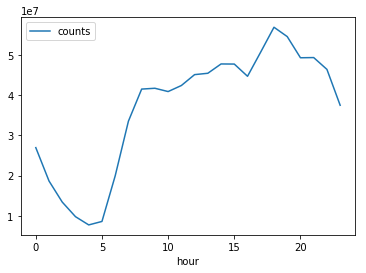

In [13]:
groupByHourDf = finalDf.groupby(['hour']).sum().reset_index()
print(groupByHourDf)
groupByHourDf.set_index('hour').plot()

                      partOfDay  hour     counts
0  1-Mid Night to Early Morning   105   85186002
1                     2-Morning   280  177740505
2                        3-Noon   455  228637622
3                   4-Afternoon   630  256415266
4                       5-Night   462  133363357


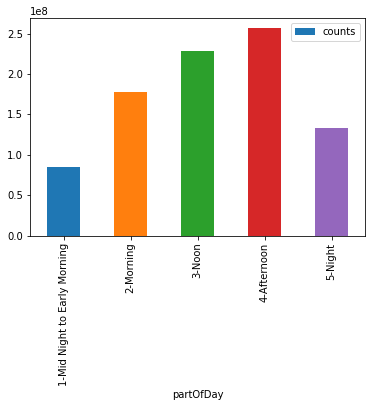

In [14]:
def partOfDay(hour):
    if hour <= 5: return "1-Mid Night to Early Morning"
    if hour <= 10 and hour > 5: return "2-Morning"
    if hour <= 15 and hour > 10: return "3-Noon"
    if hour <= 20 and hour > 15: return "4-Afternoon"
    if hour <= 24 and hour > 20: return "5-Night"
    
finalDf['partOfDay'] = finalDf['hour'].apply(partOfDay)
groupByPartOfDayDf = finalDf.groupby(['partOfDay']).sum().reset_index()
print(groupByPartOfDayDf)
groupByPartOfDayDf.set_index('partOfDay').plot.bar(y='counts')

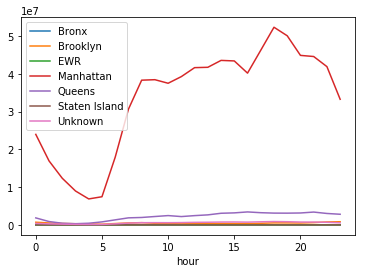

In [15]:
broughDf = pd.DataFrame(finalDf.pivot_table(values='counts', index=['hour','partOfDay'], columns='Borough').to_records())
broughDf.set_index('hour').plot()

In [16]:
#broughDf.drop(['hour'], axis=1, inplace=True)
partOfDayDf = broughDf.groupby(['partOfDay']).sum().reset_index()
print(partOfDayDf)

                      partOfDay  hour   Bronx  Brooklyn   EWR  Manhattan  \
0  1-Mid Night to Early Morning    15  146408   2391499  1447   76606346   
1                     2-Morning    40  243240   2234708  3949  162844021   
2                        3-Noon    65  184591   1675374  5939  209629559   
3                   4-Afternoon    90  169269   2344805  7008  233751859   
4                       5-Night    66   87252   2243815   606  119767157   

     Queens  Staten Island  Unknown  
0   4761488           2880  1275934  
1   9877118           1936  2535533  
2  13603156           2191  3536812  
3  16074234           2226  4065865  
4   9254050           1126  2009351  


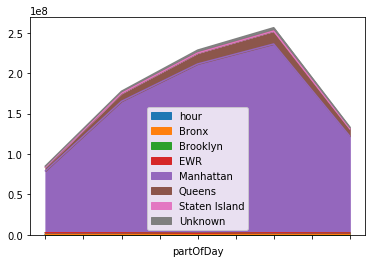

In [18]:
partOfDayDf.set_index('partOfDay').plot.area(stacked=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x01535790>,
      dtype=object)

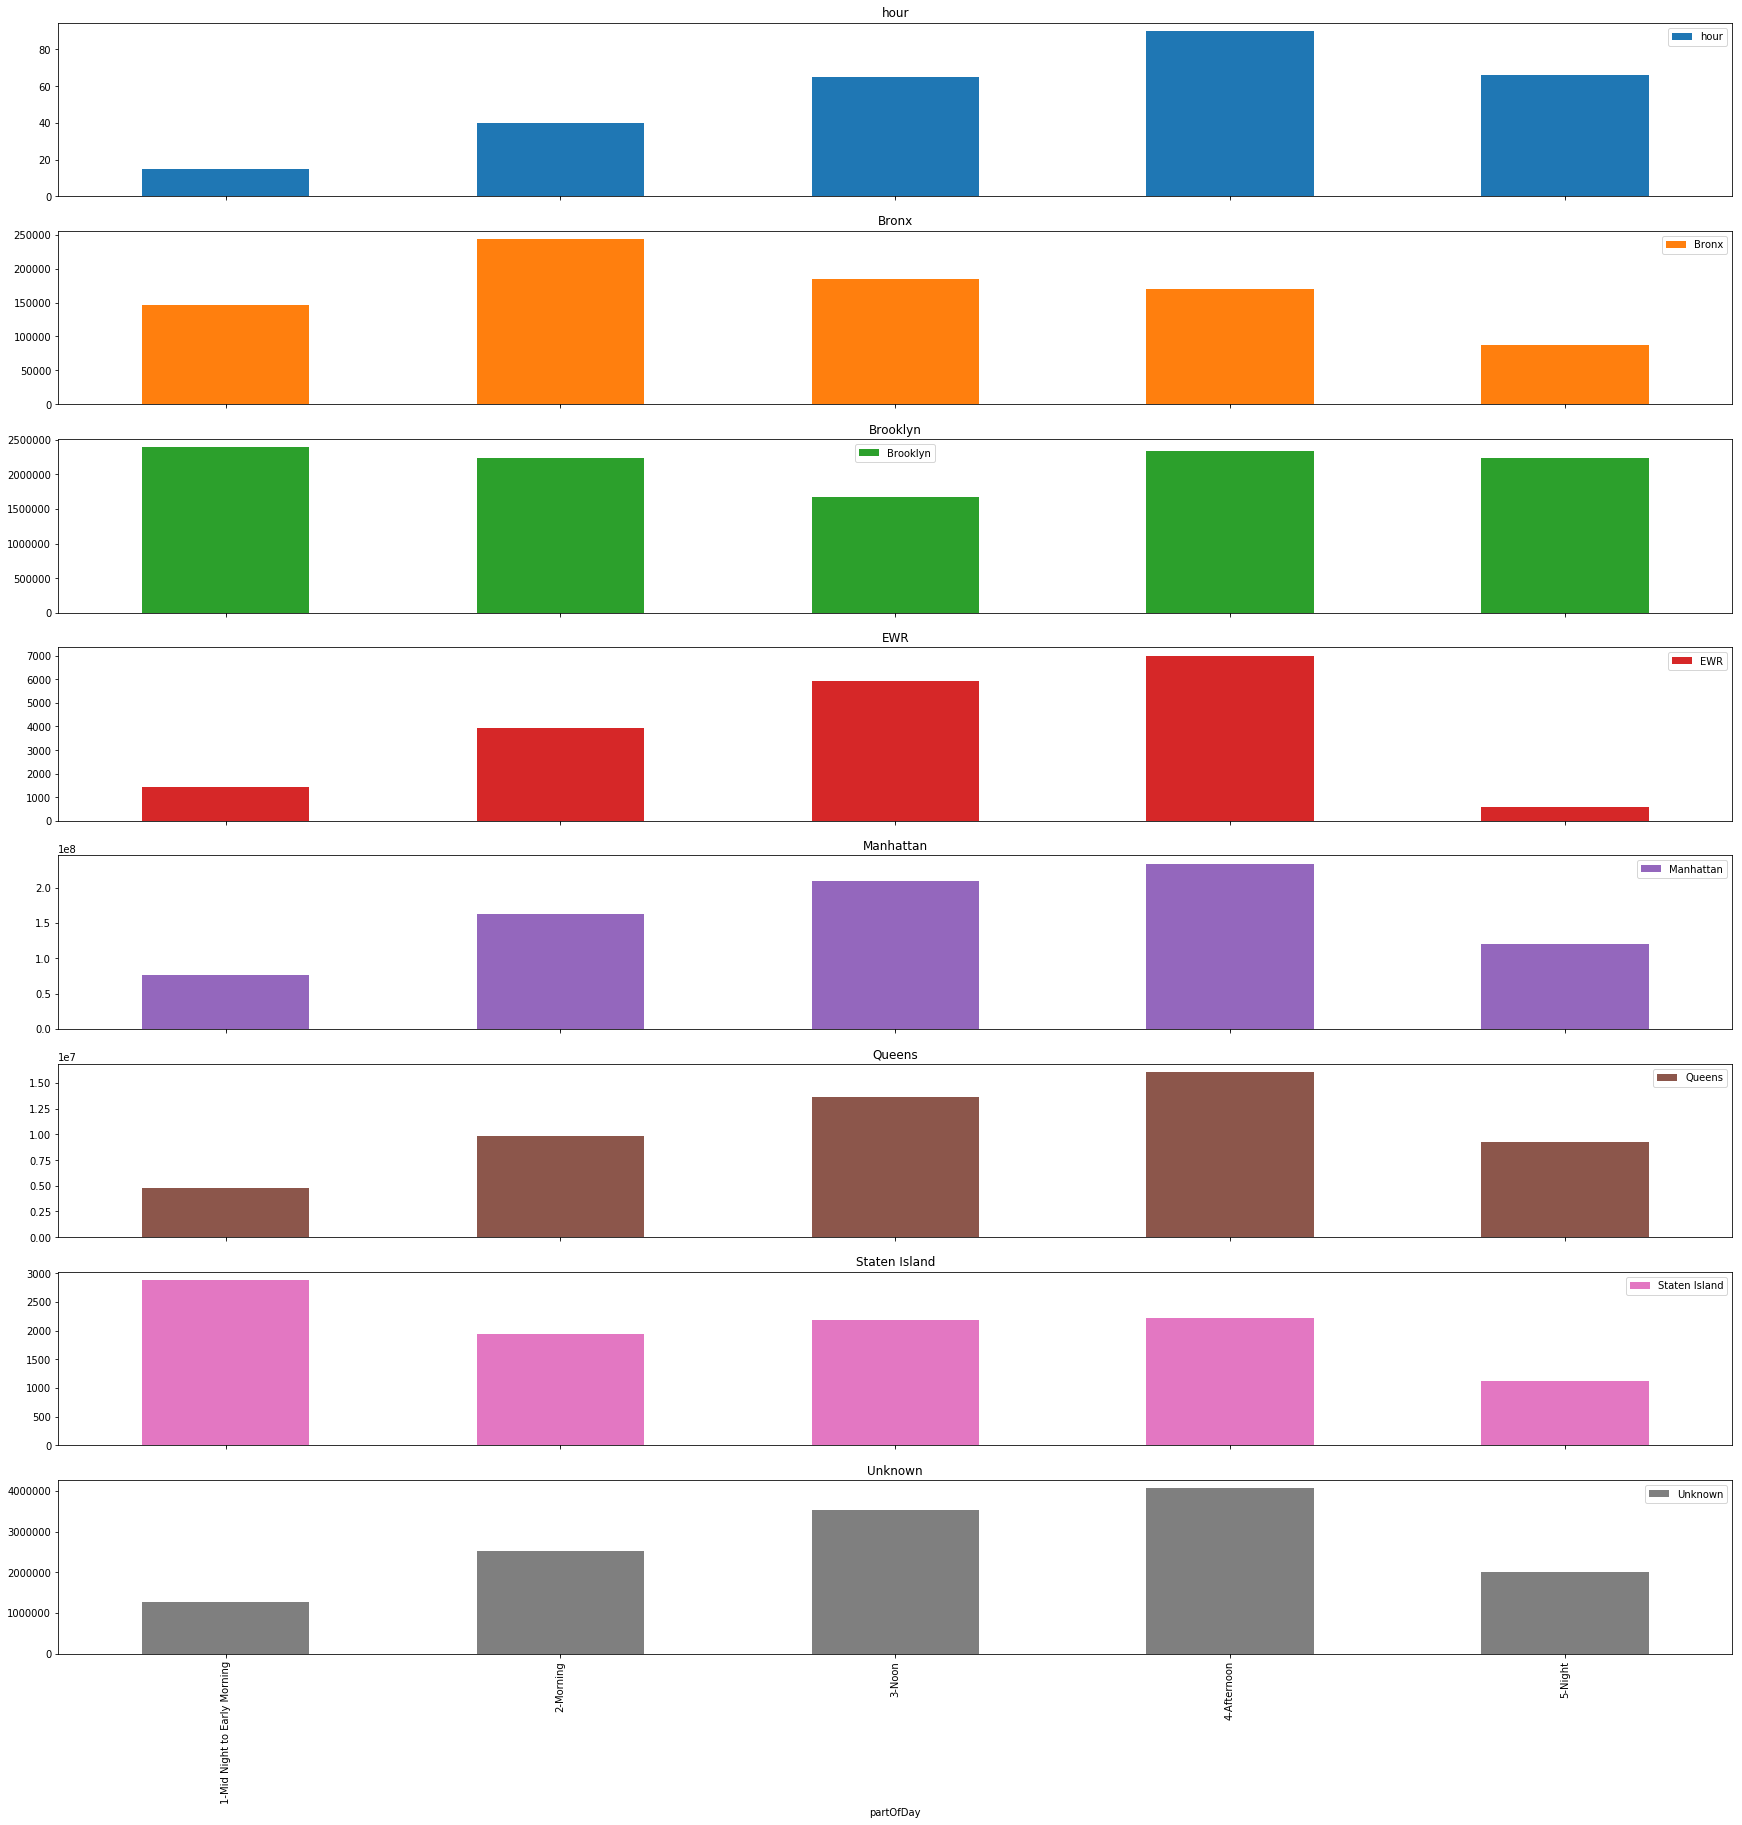

In [19]:
partOfDayDf.set_index('partOfDay').plot.bar(subplots=True,figsize =(30,30))